![SpotifyxRVB](Spotify%20x%20RVB%20-%20Logo.png)

# <a><center> Spotify x Reverberation Radio - The essence of Cool </center></a>
<b>Author: Ulysse Zampogna</b>


The project consists in revealing the secrets of the best radio on earth (according to me): Reverberation radio. It is composed of a collective of artists (musicians, djs, record labels, visual artisits, etc.) based in Austin texas, regularly featuring guests apperarences from all over the world. The radio releases a show on a weekly basis. The music selection is excquisit and covers an eclectic range of music history. 

But what make this radio so special? Let's compare it with a few popular playlists on Spotify and try to define the Reverberation's essence of Cool. 

This Data Science project is broken down in 3 notebooks:
 - [Part 1](https://github.com/uzampogn/Spotify-x-Reverberation-The-essence-of-cool) uses [Spotipy API](https://spotipy.readthedocs.io/en/2.19.0/) to collect data from a dozen of playlists. 
 - [Part 2](https://github.com/uzampogn/Spotify-x-Reverberation-The-essence-of-cool) performs an exploratory data analysis to unveal the secrets of each playlist. 
 - [Part 3](https://github.com/uzampogn/Spotify-x-Reverberation-The-essence-of-cool) is a series of classifiers ([Naïve Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html), [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) & [XGBoost](https://xgboost.readthedocs.io/en/stable/)) which takes any track and predicts the best matching playlist. Let's see if a given track could enter the exquisit Reverberation playlist.

---
# Part 3: Multi-class classifiers

Objective: Train a series of classifiers and compare their performance in terms of predictive power, complexity and running time.

### Table of content <a name="00"></a>

1. <a href='#1'>Classes defintion</a> - <a href='#1.1'>Notes</a><br>
2. <a href='#2'>Split dataset in Train/Test files</a><br>
3. <a href='#3'>Feature engineering</a><br>
   3.1 Functions definition<br>
   3.2 Pipeline creation & testing<br>
4. <a href='#4'>Classifiers comparison</a><br>
   4.1 Dummy classifier<br>
   4.2 Naïve Bayes classifier<br>
   4.3 Random Forest classifier<br>
   4.4 XGBoost classifier<br>
5. <a href='#5'>Hyperparameters Tuning with imbalanced data</a><br>
   5.1 Combined - over & under - sampling techniques for imbalanced data<br>
   5.2 Random Forest tuning and features importance exploration<br>
   5.3 XGBoost tuning<br>
7. <a href='#7'>Conclusion</a><br>
    7.1 Models comparison<br>
    7.2 Spotify x Reverberation Radio - End<br>
8. <a href='#7'>Appendix</a><br>
   
 ---
 
#### Settings

In [7]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc,precision_score, accuracy_score, recall_score, f1_score, matthews_corrcoef


pd.set_option('display.max_rows', None)
%matplotlib inline
sns.set(style="ticks", context="poster")
plt.style.use("seaborn-poster")
%autosave 30

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Autosaving every 30 seconds


In [8]:
df = pd.read_csv('../data/rvb_data.csv')

In [9]:
df.head()

,playlist,id,name,album,artist,genres,release_date,popularity,acousticness,danceability,...,valence,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,duration_ms,mode,type
0,Today's Top Hits,3USxtqRwSYz57Ewm6wWRMp,Heat Waves,Dreamland,Glass Animals,"['gauze pop', 'indietronica', 'shiver pop']",2020-08-07,90,0.4400,0.761,...,0.531,0.000007,0.0921,-6.900,0.0944,80.870,4,238805,1,audio_features
1,Today's Top Hits,5HCyWlXZPP0y6Gqq8TgA20,STAY (with Justin Bieber),STAY (with Justin Bieber),The Kid LAROI,['australian hip hop'],2021-07-09,97,0.0383,0.591,...,0.478,0.000000,0.1030,-5.484,0.0483,169.928,4,141805,1,audio_features
2,Today's Top Hits,6zSpb8dQRaw0M1dK8PBwQz,Cold Heart - PNAU Remix,Cold Heart (PNAU Remix),Elton John,"['glam rock', 'mellow gold', 'piano rock']",2021-08-13,96,0.0340,0.796,...,0.942,0.000042,0.0952,-6.312,0.0317,116.032,4,202735,1,audio_features
3,Today's Top Hits,0gplL1WMoJ6iYaPgMCL0gX,Easy On Me,Easy On Me,Adele,"['british soul', 'pop', 'pop soul', 'uk pop']",2021-10-14,97,0.5780,0.604,...,0.130,0.000000,0.1330,-7.519,0.0282,141.981,4,224694,1,audio_features
4,Today's Top Hits,4fouWK6XVHhzl78KzQ1UjL,abcdefu,abcdefu,GAYLE,['modern alternative pop'],2021-08-13,100,0.2990,0.695,...,0.415,0.000000,0.3670,-5.692,0.0493,121.932,4,168601,1,audio_features


---
## 1. Classes definition <a name='1'></a>
<a href='#00'>(Go to Table of Content)</a>

In [10]:
# Initiating color mapping to ensure consistency across all further visualizations

#https://matplotlib.org/stable/gallery/color/named_colors.html
pl_mapping = {
 "Today's Top Hits":'tab:blue',
 'Your Favorite CoffeeHouse':'tab:orange',
 'RapCaviar':'tab:green',
 'Viva Latino':'gold',
 'Hot Country':'tab:purple',
 'New Music Friday':'tab:brown',
 'Peaceful Piano':'tab:pink',
 'Are & Be':'tab:gray',
 'Mint':'tab:olive',
 'Just Hits':'tab:cyan',
 'Soft Pop Hits':'lime',
 'All Out 2000s':'royalblue',
 'Reverberation':'crimson'
}

pl_mapping = dict(sorted(pl_mapping.items(), key=lambda item: item[0]))
pl_mapping_list = [item[1] for item in pl_mapping.items()]

In [11]:
multi_class = df.groupby(['playlist']).size().reset_index(name='size')

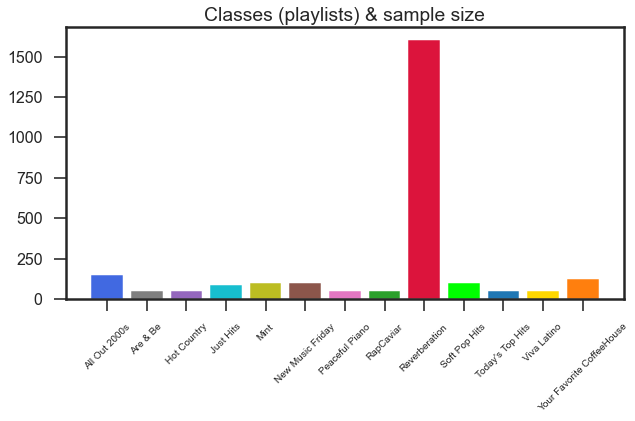

In [12]:
plt.figure(figsize=(10,5))
plt.bar(multi_class['playlist'],multi_class['size'],color=pl_mapping_list)
plt.xticks(size=10,rotation=45)
plt.title('Classes (playlists) & sample size')
plt.show()

In [13]:
multi_class['% of Total'] = multi_class['size']/multi_class['size'].sum()
multi_class.sort_values(by='size',ascending=False)

,playlist,size,% of Total
8,Reverberation,1602,0.624318
0,All Out 2000s,150,0.058457
12,Your Favorite CoffeeHouse,125,0.048714
4,Mint,100,0.038971
5,New Music Friday,100,0.038971
9,Soft Pop Hits,100,0.038971
3,Just Hits,87,0.033905
2,Hot Country,52,0.020265
1,Are & Be,50,0.019486
6,Peaceful Piano,50,0.019486


**Note:** <a name='1.1'></a>

Reverberation playlist constitutes 62% of our datasets. Thus, we are comfronted to a typical class imbalance problem in a multi-class classification scenario. Generally in this case, models don't generalize well on minority classes. Moreover, some minority classes in our dataset contains very few instances - complicating further the challenge. 

We will explore various techniques and models to deal with this situation.

<a href='#00'>(Go to Table of Content)</a>

---
## 2. Split dataset in Train/Test files <a name='2'></a>
<a href='#00'>(Go to Table of Content)</a>

In [14]:
df.shape

(2566, 21)

In [15]:
df.columns

Index(['playlist', 'id', 'name', 'album', 'artist', 'genres', 'release_date',
       'popularity', 'acousticness', 'danceability', 'energy', 'valence',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'time_signature', 'duration_ms', 'mode', 'type'],
      dtype='object')

In [16]:
y = df.playlist

In [17]:
X = df[['genres', 'release_date',
       'popularity', 'acousticness', 'danceability', 'energy', 'valence',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'time_signature', 'duration_ms', 'mode']]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=72)

In [19]:
print('Verify if X (features) and y (target/class) arrays have the same number of rows and only 1 column for y.')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

Verify if X (features) and y (target/class) arrays have the same number of rows and only 1 column for y.
X_train shape: (2052, 15)
y_train shape: (2052,)
X_test shape: (514, 15)
y_test shape: (514,)


---
## 3. Feature engineering <a name='3'></a>
<a href='#00'>(Go to Table of Content)</a>

In Part 2 of this notebook series, we've explored various aggregation of certain features. The knowledge previously acquired will be used to perform feature engineering and address one specific challenge - the volatily of the genre aka "style" feature between train, test files as well as in a new dataset at inference time. The style is composed of highly specific genres, such as "deep new americana". These very specific genres will vary across datasets - essentially rendering an error while computing the model. For example, applying one-hot encoding on the test data will yield errors as new styles unknown to the train dataset will be created as features. Certain models, like XGBoost, are immune to such errors but the vast majority of models aren't. 

One solution is to manually create a new feature called "Major Genres". We've already used it in the EDA to better understand specificities of each playlist. It consists in extracting major genre like "pop" or "rap" and classify all highly specialized genres in a single category called "Others". This solution enables to use any model as features are consistent across datasets. However, we may loose prediction power by generalizing too much - especially for playlists with few instances and similar major genres distribution.

An alternative option is to use feature selection methods for categorical and numerical predictors such as [chi-square](https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223) and [ANOVA](https://towardsdatascience.com/anova-for-feature-selection-in-machine-learning-d9305e228476) to determine the strength of the relationship between predictors and a categorical target variable. Then, using this newly acquired knowledge to filter out the noise generated by highly specialized genres. We may benefit from keeping the best predictive power of specific genres while filtering out the rest.


### 3.1. Functions definition: <a name='3.1'></a>

In [20]:
def extract_decades(f):
    f = f.copy(deep=True)
    # Release_date is treated as an object type. 's transform it ot datetime.
    f.loc[:,'release_date'] = pd.to_datetime(f.loc[:,'release_date'])
    #df.info()

    # Extract Year from release_date
    f.loc[:,'year'] = f['release_date'].dt.year
    f.loc[:,'month'] = f['release_date'].dt.month
    f.loc[:,'release_decade'] = f['year'].apply(lambda row: str(row)[:2]+str(row)[2]+'0s')
    
    return f

In [21]:
# 16 selected major genres from the Top 5 genres per playlist
major_genres = ['latin','hip hop','rock','soul','r&b'\
              ,'edm','rap','folk','indie','country'\
              ,'americana','house','alt z','pop','bossa nova','reggaeton']

features_selection=['popularity', 'acousticness', 'danceability',
       'energy', 'valence', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'time_signature', 'duration_ms', 'mode',
       'release_decade','year', 'month', 'major_genres'] #, 'style'

def major_mapping(row):
    if row == "None":
        return 'None'
    
    for major in major_genres:
        if major in row:
            return major
        
    return 'Others'


def extract_genres(f):
    f = f.copy(deep=True)
    #Create style column
    f.loc[:,'style'] =  f.loc[:,'genres'].apply(lambda row: row.split(',')[0] if ',' in row else row)\
                .replace("[\(['{}')\]]", '',regex=True)
    f['style'].replace(r'^\s*$', "None", regex=True,inplace=True)

    
    # Create major genres column
    f.loc[:,'major_genres'] =  f['style'].apply(lambda row: major_mapping(row))
    
    return f[features_selection]

def mode_transformation(f):
    f.copy(deep=True)
    f[['mode','time_signature']] = f[['mode','time_signature']].astype('object')
    return f

In [22]:
X_train, X_test = map(extract_decades,[X_train,X_test])
X_train, X_test = map(extract_genres,[X_train,X_test])
X_train, X_test = map(mode_transformation,[X_train,X_test])

In [23]:
X_train.describe()

,popularity,acousticness,danceability,energy,valence,instrumentalness,liveness,loudness,speechiness,tempo,duration_ms,year,month
count,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2052.000000,2.052000e+03,2052.000000,2052.000000
mean,35.987817,0.353491,0.593528,0.569646,0.564653,0.167917,0.172874,-9.426566,0.063944,117.578828,2.203085e+05,2005.816764,5.264620
std,30.295028,0.316143,0.155177,0.205495,0.244734,0.297390,0.141236,4.219645,0.063422,27.509222,7.984672e+04,17.822423,3.981632
min,0.000000,0.000009,0.156000,0.006810,0.000010,0.000000,0.024400,-33.522000,0.022700,46.591000,3.999600e+04,1956.000000,1.000000
25%,6.000000,0.056575,0.487000,0.423000,0.377750,0.000002,0.093175,-11.881000,0.032500,96.439500,1.713565e+05,2000.000000,1.000000
50%,32.000000,0.252500,0.604000,0.581000,0.573000,0.001055,0.117500,-8.669500,0.040500,116.614500,2.035130e+05,2014.000000,5.000000
75%,62.000000,0.621000,0.706000,0.731000,0.770000,0.176000,0.194250,-6.258000,0.061500,133.637000,2.466998e+05,2020.000000,9.000000
max,100.000000,0.995000,0.975000,0.994000,0.986000,0.977000,0.977000,-1.538000,0.551000,204.973000,1.000688e+06,2022.000000,12.000000


### 3.2. Pipeline creation & testing:<a name='3.2'></a>


#### Pipeline: Distinction between numeric and categorical variables

In [24]:
def numeric_variables(f):
    return f.select_dtypes(exclude='object').columns

def categorical_variables(f):
    return f.select_dtypes(include='object').columns

X_train_num_var, X_test_num_var = map(numeric_variables,[X_train,X_test])
X_train_cat_var, X_test_cat_var = map(categorical_variables,[X_train,X_test])

#### Pipeline: Pre-processing

In [25]:
#https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first',sparse=False))])

#https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X_train_num_var),
        ('cat', categorical_transformer, X_train_cat_var)])

#### Test pre-preprocessing

In [26]:
pre = Pipeline(steps=[('preprocessor',preprocessor)])
pre.fit(X_train)

preprocessor_features_ = (pre.named_steps['preprocessor'].transformers_[1][1]
                            .named_steps['onehot']
                            .get_feature_names_out(X_train_cat_var)
                         )

In [27]:
print(f'Verify features list after Pipeline fitting: \n\n {preprocessor_features_}')

Verify features list after Pipeline fitting: 

 ['time_signature_3' 'time_signature_4' 'time_signature_5' 'mode_1'
 'release_decade_1960s' 'release_decade_1970s' 'release_decade_1980s'
 'release_decade_1990s' 'release_decade_2000s' 'release_decade_2010s'
 'release_decade_2020s' 'major_genres_Others' 'major_genres_alt z'
 'major_genres_americana' 'major_genres_bossa nova' 'major_genres_country'
 'major_genres_edm' 'major_genres_folk' 'major_genres_hip hop'
 'major_genres_house' 'major_genres_indie' 'major_genres_latin'
 'major_genres_pop' 'major_genres_r&b' 'major_genres_rap'
 'major_genres_reggaeton' 'major_genres_rock' 'major_genres_soul']


---
## 4. Classifiers comparison <a name='4'></a> 
<a href='#00'>(Go to Table of Content)</a>

### 4.1. Dummy Classifier

In [28]:
%%time
# Pipeline settings
#https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
dc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DummyClassifier(strategy='most_frequent'))])
# Fit
dc.fit(X_train,y_train)

# Predict
y_train_pred = dc.predict(X_train)
y_test_pred = dc.predict(X_test)

CPU times: user 35.2 ms, sys: 3.04 ms, total: 38.3 ms
Wall time: 39.1 ms


#### Dummy Classifier: Confusion Matrix

In [29]:
cm = confusion_matrix(y_test,y_test_pred)

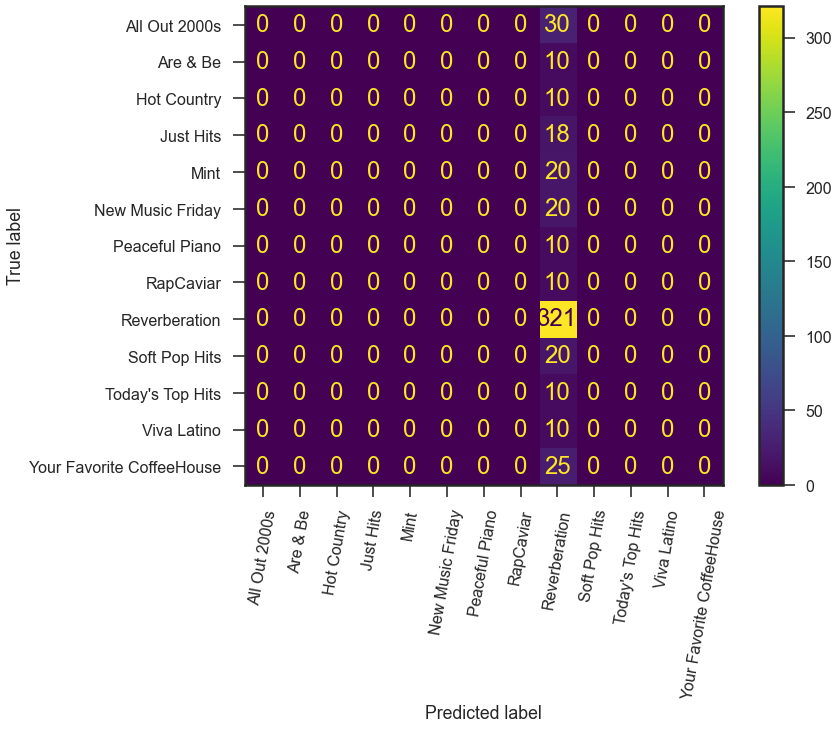

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dc.classes_)
disp.plot()
plt.xticks(rotation=80)
plt.show()

In [31]:
print(f'Accuracy for train data:   {accuracy_score(y_train, y_train_pred):.3f}\n')
print(f'Accuracy for test data:    {accuracy_score(y_test, y_test_pred):.3f}\n')
print(f"Matthew's correlation coefficient for test data:    {matthews_corrcoef(y_test, y_test_pred):.3f}\n")
print('--------------------\n')
print(f'Classification report for test data:\n\n{classification_report(y_test, y_test_pred,zero_division=0)}')

Accuracy for train data:   0.624

Accuracy for test data:    0.625

Matthew's correlation coefficient for test data:    0.000

--------------------

Classification report for test data:

                           precision    recall  f1-score   support

            All Out 2000s       0.00      0.00      0.00        30
                 Are & Be       0.00      0.00      0.00        10
              Hot Country       0.00      0.00      0.00        10
                Just Hits       0.00      0.00      0.00        18
                     Mint       0.00      0.00      0.00        20
         New Music Friday       0.00      0.00      0.00        20
           Peaceful Piano       0.00      0.00      0.00        10
                RapCaviar       0.00      0.00      0.00        10
            Reverberation       0.62      1.00      0.77       321
            Soft Pop Hits       0.00      0.00      0.00        20
         Today's Top Hits       0.00      0.00      0.00        10
        

Classification report - Glossary:

* **Precision** – Accuracy of positive predictions.<br>
    Precision = TP/(TP + FP)
* **Recall** – What percent of the positive cases did you catch? <br>
    Recall = TP / (TP + FN)
* **F1 score** – What percent of positive predictions were correct? <br>
    F1 Score (harmonic mean of precision and recall) = 2*(Recall * Precision) / (Recall + Precision)
* **Support** = occurrences of the class in the specified dataset


* **Accuracy** - correct prediction overall.<br>
    Accuracy = (TP+TN)/(TP+FP+TN+FN)
* **Macro avg** = F1-score mean
* **Weighted avg** = F1-score weighted mean by support

#### Notes on Dummy Classifier: <a name='4.1.1'></a>

Let's assess classifers according to 3 aspects:
   * **Predictive Power**: It works quite well as we have an highly imbalanced datasets. Reveberation Radio composes 62% of tracks in the datasets. Hence, the overall accurary is also 62%. 
   * **Complexity**: The dummy classifier uses simple techniques. Here, we're always prediciting the majority class. 
   * **Running time**: Due to its low computation, the classifiers is extermely fast 38.3 ms.

Dummy classifiers are used to create a benchmark of a naïve and simple solution. Further algorithms will have to beat the performance of such solution to be deemed efficient.

---
### 4.2. Naïve Bayes

In [32]:
%%time
# Pipeline settings
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
gnb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GaussianNB())])
# Fit
gnb.fit(X_train,y_train)

# Predict
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)

CPU times: user 43.1 ms, sys: 4.41 ms, total: 47.5 ms
Wall time: 50.2 ms


#### Naïve Bayes: Confusion Matrix

In [33]:
cm = confusion_matrix(y_test,y_test_pred)

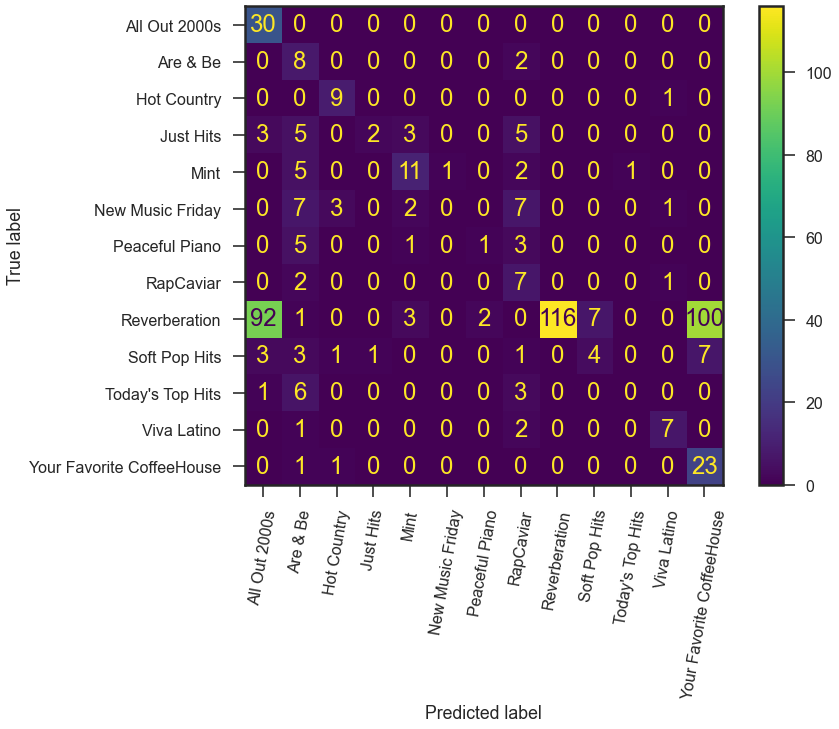

In [34]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
plt.xticks(rotation=80)
plt.show()

In [35]:
print(f'Accuracy for train data:   {accuracy_score(y_train, y_train_pred):.3f}\n')
print(f'Accuracy for test data:    {accuracy_score(y_test, y_test_pred):.3f}\n')
print(f"Matthew's correlation coefficient for test data:    {matthews_corrcoef(y_test, y_test_pred):.3f}\n")
print('--------------------\n')
print(f'Classification report for test data:\n\n{classification_report(y_test, y_test_pred,zero_division=0)}')

Accuracy for train data:   0.438

Accuracy for test data:    0.424

Matthew's correlation coefficient for test data:    0.360

--------------------

Classification report for test data:

                           precision    recall  f1-score   support

            All Out 2000s       0.23      1.00      0.38        30
                 Are & Be       0.18      0.80      0.30        10
              Hot Country       0.64      0.90      0.75        10
                Just Hits       0.67      0.11      0.19        18
                     Mint       0.55      0.55      0.55        20
         New Music Friday       0.00      0.00      0.00        20
           Peaceful Piano       0.33      0.10      0.15        10
                RapCaviar       0.22      0.70      0.33        10
            Reverberation       1.00      0.36      0.53       321
            Soft Pop Hits       0.36      0.20      0.26        20
         Today's Top Hits       0.00      0.00      0.00        10
        

Classification report - Glossary:

* **Precision** – Accuracy of positive predictions.<br>
    Precision = TP/(TP + FP)
* **Recall** – What percent of the positive cases did you catch? <br>
    Recall = TP / (TP + FN)
* **F1 score** – What percent of positive predictions were correct? <br>
    F1 Score (harmonic mean of precision and recall) = 2*(Recall * Precision) / (Recall + Precision)
* **Support** = occurrences of the class in the specified dataset


* **Accuracy** - correct prediction overall.<br>
    Accuracy = (TP+TN)/(TP+FP+TN+FN)
* **Macro avg** = F1-score mean
* **Weighted avg** = F1-score weighted mean by support

#### Notes on Naïve Bayes Classifier: <a name='4.2.1'></a>

Let's assess classifers according to 3 aspects:
   * **Predictive Power**: Unfortunately, NB performs worse than our Dummy classifier. It only yields 42% accurarcy.
   * **Complexity**: NB is a straightforward model utilizing solely probabilities. 
   * **Running time**: Due to its low computation, the classifiers is extermely fast 50.4 ms.

Naïve Bayes can be fast and relatively efficient if a series of underlying assumptions are respected. The most important one being independence among features. We know we violate this assumption during the preprocessing as we include all hot-encoded features. Plus, we know that certain audio features are highly correlated.

---
### 4.3. Random Forest classifier

In [36]:
%%time
# Pipeline settings
rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier(class_weight='balanced'
                                                           ,n_jobs=-1
                                                           ,random_state=72))])
# Fit
rf.fit(X_train,y_train)

# Predict
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

CPU times: user 718 ms, sys: 116 ms, total: 833 ms
Wall time: 470 ms


#### Random Forest: Confusion Matrix

In [37]:
cm = confusion_matrix(y_test,y_test_pred)

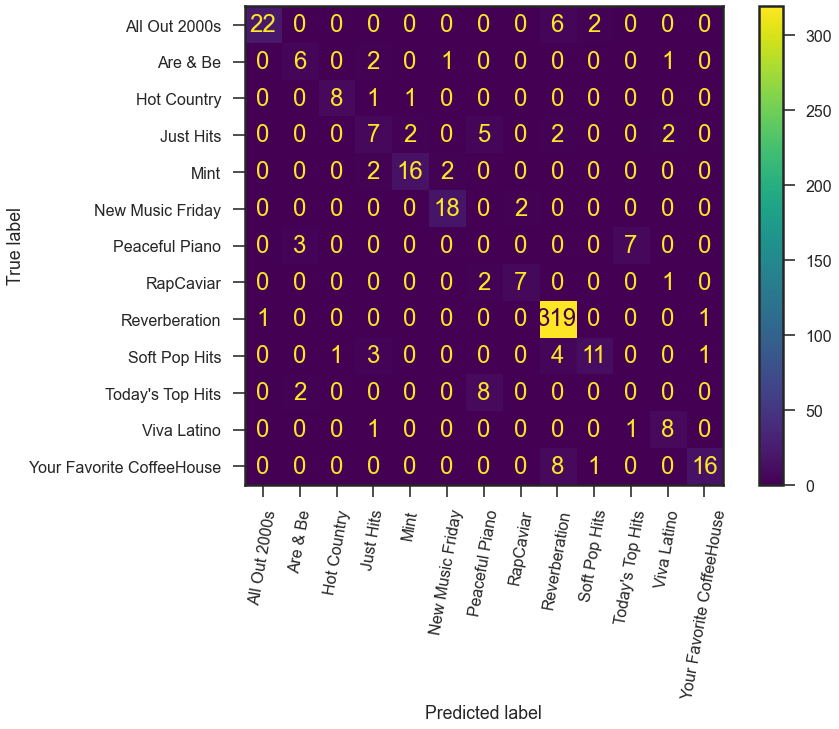

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
disp.plot()
plt.xticks(rotation=80)
plt.show()

In [39]:
print(f'Accuracy for train data:   {accuracy_score(y_train, y_train_pred):.3f}\n')
print(f'Accuracy for test data:    {accuracy_score(y_test, y_test_pred):.3f}\n')
print(f"Matthew's correlation coefficient for test data:    {matthews_corrcoef(y_test, y_test_pred):.3f}\n")
print('--------------------\n')
print(f'Classification report for test data:\n\n{classification_report(y_test, y_test_pred,zero_division=0)}')

Accuracy for train data:   0.961

Accuracy for test data:    0.852

Matthew's correlation coefficient for test data:    0.745

--------------------

Classification report for test data:

                           precision    recall  f1-score   support

            All Out 2000s       0.96      0.73      0.83        30
                 Are & Be       0.55      0.60      0.57        10
              Hot Country       0.89      0.80      0.84        10
                Just Hits       0.44      0.39      0.41        18
                     Mint       0.84      0.80      0.82        20
         New Music Friday       0.86      0.90      0.88        20
           Peaceful Piano       0.00      0.00      0.00        10
                RapCaviar       0.78      0.70      0.74        10
            Reverberation       0.94      0.99      0.97       321
            Soft Pop Hits       0.79      0.55      0.65        20
         Today's Top Hits       0.00      0.00      0.00        10
        

Classification report - Glossary:

* **Precision** – Accuracy of positive predictions.<br>
    Precision = TP/(TP + FP)
* **Recall** – What percent of the positive cases did you catch? <br>
    Recall = TP / (TP + FN)
* **F1 score** – What percent of positive predictions were correct? <br>
    F1 Score (harmonic mean of precision and recall) = 2*(Recall * Precision) / (Recall + Precision)
* **Support** = occurrences of the class in the specified dataset


* **Accuracy** - correct prediction overall.<br>
    Accuracy = (TP+TN)/(TP+FP+TN+FN)
* **Macro avg** = F1-score mean
* **Weighted avg** = F1-score weighted mean by support

#### Notes on Random Forest Classifier: <a name='4.3.1'></a>

Let's assess classifers according to 3 aspects:
   * **Predictive Power**: RF improved significantly the accurary of the model - especially for minorities classes. The overall accuracy reaches 85%. It's still heavily biased towards the majority class (Reverberation) which has an almost perfect accuracy. Looking at the macro avg of 63%, we see there is improvement to be made in order to improve prediction on minority classes.
   * **Complexity**: RF is a powerful tree based model. We were able to improve the overall prediction power without even tuning hyperparameters. We will explore the tuning later on. 
   * **Running time**: RF is inevitably slower than previous classifiers as complex tree and bagging task are completed. RF without any hyperparameter tuning runs in 770 ms.

Random Forest is one of the most convenient and powerful tree based model. Thanks to its bagging architecture, it combines the power of many small trees to improve overall generalization. As per all tree based model, RF is prone to overfitting. We'll explore hyperparameter tuning to assess if we can improve the model.

---
### 4.4. XGBoost classifier

In [40]:
%%time
# Pipeline settings
xgb = Pipeline_imb(steps=[('preprocessor', preprocessor),('classifier', XGBClassifier(eval_metric='mlogloss'))])
# Fit
xgb.fit(X_train,y_train)

#  Predict
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 12.3 s, sys: 112 ms, total: 12.4 s
Wall time: 3.46 s


#### XGBoost: Confusion Matrix

In [41]:
cm = confusion_matrix(y_test,y_test_pred)

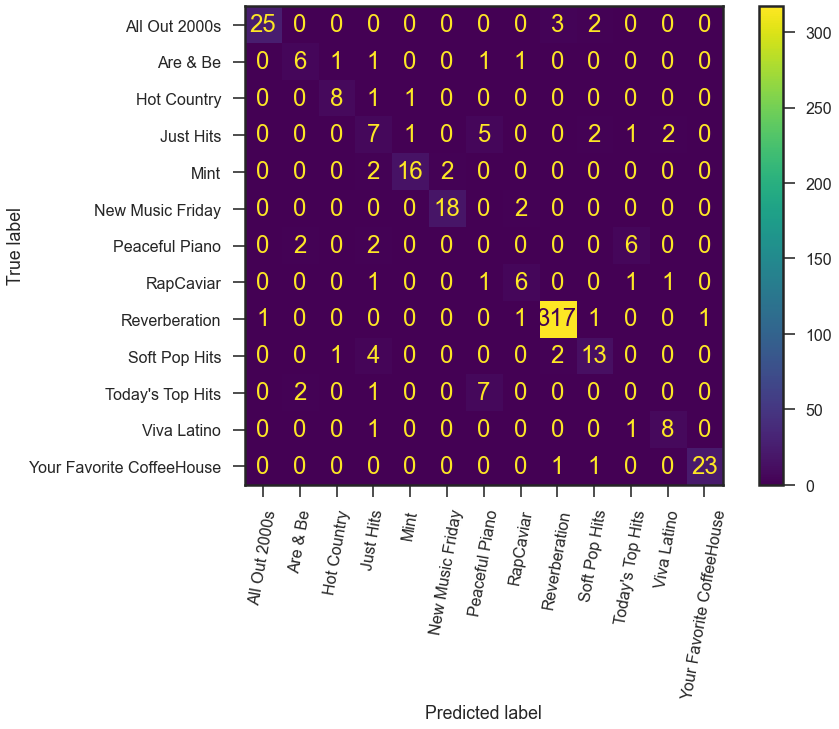

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb.classes_)
disp.plot()
plt.xticks(rotation=80)
plt.show()

In [43]:
print(f'Accuracy for train data:   {accuracy_score(y_train, y_train_pred):.3f}\n')
print(f'Accuracy for test data:    {accuracy_score(y_test, y_test_pred):.3f}\n')
print(f"Matthew's correlation coefficient for test data:    {matthews_corrcoef(y_test, y_test_pred):.3f}\n")
print('--------------------\n')
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(f'Classification report for test data:\n\n{classification_report(y_test, y_test_pred,zero_division=0)}')
#https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

Accuracy for train data:   0.961

Accuracy for test data:    0.870

Matthew's correlation coefficient for test data:    0.781

--------------------

Classification report for test data:

                           precision    recall  f1-score   support

            All Out 2000s       0.96      0.83      0.89        30
                 Are & Be       0.60      0.60      0.60        10
              Hot Country       0.80      0.80      0.80        10
                Just Hits       0.35      0.39      0.37        18
                     Mint       0.89      0.80      0.84        20
         New Music Friday       0.90      0.90      0.90        20
           Peaceful Piano       0.00      0.00      0.00        10
                RapCaviar       0.60      0.60      0.60        10
            Reverberation       0.98      0.99      0.98       321
            Soft Pop Hits       0.68      0.65      0.67        20
         Today's Top Hits       0.00      0.00      0.00        10
        

Classification report - Glossary:

* **Precision** – Accuracy of positive predictions.<br>
    Precision = TP/(TP + FP)
* **Recall** – What percent of the positive cases did you catch? <br>
    Recall = TP / (TP + FN)
* **F1 score** – What percent of positive predictions were correct? <br>
    F1 Score (harmonic mean of precision and recall) = 2*(Recall * Precision) / (Recall + Precision)
* **Support** = occurrences of the class in the specified dataset


* **Accuracy** - correct prediction overall.<br>
    Accuracy = (TP+TN)/(TP+FP+TN+FN)
* **Macro avg** = F1-score mean
* **Weighted avg** = F1-score weighted mean by support

#### Notes on XGBoost Classifier: <a name='4.4.1'></a>

Let's assess classifers according to 3 aspects:
   * **Predictive Power**: XGBoost improved its predicitive power with respect to RF. Both the overall accuracy and macro avg increased to 87% and 64% respectively.
   * **Complexity**: XGBoost is a powerful tree based model. We were able to improve the overall prediction power without even tuning hyperparameters. We will explore the tuning later on. 
   * **Running time**: XGBoost is must slower with 12.4 s running time compared to 770ms for RF.

XGBoost is an industry standard. The algorithm proposed many hyperparameters to tune its predictive power as well as its running time. Another advantage is its ability to handle error automatically - for example, we could use inconsistency in features across various datasets can be handled by XGBoost. RF does not offer this feature.

---
## 5. Hyperparameter tuning with imbalanced data <a name='5'></a> 
<a href='#00'>(Go to Table of Content)</a>

Tuning is generally a computationally intensive phase. Thus, I used Google Colab to tune both RandomForest and XGBoost classifiers. You can access the Google Colab notebook [here](https://colab.research.google.com/drive/1HJ5Z38AeDP-zWRbsUnFIFGVSC7Sz78T9?usp=sharing). 

If you're not familiar with Google Colab, check it out! It's a fantastic product enabling individuals and teams to collaborate on executable programs directly in the cloud. It comes with all major packages already installed which may save a lot of time and headaches. It also enables anybody to access free computing power in cloud. Fan-tas-tic! For more info, check [Colab - FAQ](https://research.google.com/colaboratory/faq.html#gpu-availability)

---

#### Imbalanced data:

In this section, I will also address an issue related to the imbalanced representation of each class in the dataset. I will introduce some sampling techniques to cope with it. More precisely, we will use a combination of under and over sampling techniques as well as a specific [Pipeline from the imblearn library](https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html) working with our sampling techniques.

---
### 5.1. RandomForest tuning

The following code ran on Google collab - [here](https://colab.research.google.com/drive/1HJ5Z38AeDP-zWRbsUnFIFGVSC7Sz78T9?usp=sharing).

Random Forest parameters - [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [ ]:
best_params_ = {'over_sampler__enn': EditedNearestNeighbours(n_neighbors=2)
                , 'classifier__n_estimators': 1000
                , 'classifier__min_samples_leaf': 1
                , 'classifier__max_features': 'auto'
                , 'classifier__max_depth': 9
                , 'classifier__criterion': 'gini'
                , 'classifier__class_weight': 'balanced_subsample'
                , 'classifier__bootstrap': False}
best_score_ = 0.8439321160679606

#### RandomForest tuned model

In [ ]:
%%time
# Pipeline settings
rf = Pipeline_imb(steps=[('preprocessor', preprocessor),
                     ('over_sampler', SMOTE(sampling_strategy='not majority',random_state=72)),
                     ('classifier', RandomForestClassifier(bootstrap=True,
                                                           class_weight='balanced',
                                                           criterion='gini',
                                                           max_depth=8,
                                                           max_features='log2',
                                                           min_samples_leaf=1,
                                                           n_estimators=700,
                                                           n_jobs=2,
                                                           random_state=72))])
# Fit
rf.fit(X_train,y_train)

# Predict
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(f'Accuracy for train data:   {accuracy_score(y_train, y_train_pred):.3f}\n')
print(f'Accuracy for test data:    {accuracy_score(y_test, y_test_pred):.3f}\n')
print(f"Matthew's correlation coefficient for test data:    {matthews_corrcoef(y_test, y_test_pred):.3f}\n")
print('--------------------\n')
print(f'Classification report for test data:\n\n{classification_report(y_test, y_test_pred,zero_division=0)}')

#### RandomForest - Features importance exploration

In [ ]:
num_features=pre.named_steps['preprocessor'].transformers[0][2]
cat_features=(pre.named_steps['preprocessor'].transformers_[1][1]
                                             .named_steps['onehot']
                                             .get_feature_names_out(X_train_cat_var))
features=list(num_features)+list(cat_features)
impurity_scores=rf.named_steps['classifier'].feature_importances_
feautres_impurity_scores=sorted(zip(features,impurity_scores),key=lambda x:x[1],reverse=True)

In [ ]:
feautres_impurity_scores

---
### 5.2. XGBoost tuning

The following code ran on Google collab - [here](https://colab.research.google.com/drive/1HJ5Z38AeDP-zWRbsUnFIFGVSC7Sz78T9?usp=sharing).

XGBoost parameters - [documentation](https://xgboost.readthedocs.io/en/stable/parameter.html#).

#### XGBoost tuned model

In [59]:
%%time
# Pipeline settings
xgb = Pipeline_imb(steps=[('preprocessor', preprocessor)
                          ,('over_sampler', SMOTEENN(sampling_strategy='not majority'
                                                     ,random_state=72
                                                     ,smote=SMOTE(k_neighbors=3)
                                                     ,enn=EditedNearestNeighbours(n_neighbors=0)
                                                    ))
                          ,('classifier', XGBClassifier(subsample=0.5
                                                        ,n_estimators=1500
                                                        ,max_depth=8
                                                        ,learning_rate=0.1
                                                        ,gamma=0.0001
                                                        ,alpha=10
                                                        ,colsample_bytree=0.6
                                                        ,colsample_bylevel=0.6
                                                        ,eval_metric='mlogloss'))])
# Fit
xgb.fit(X_train,y_train)

#  Predict
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 6min 16s, sys: 3.09 s, total: 6min 19s
Wall time: 1min 40s


In [60]:
cm = confusion_matrix(y_test,y_test_pred)

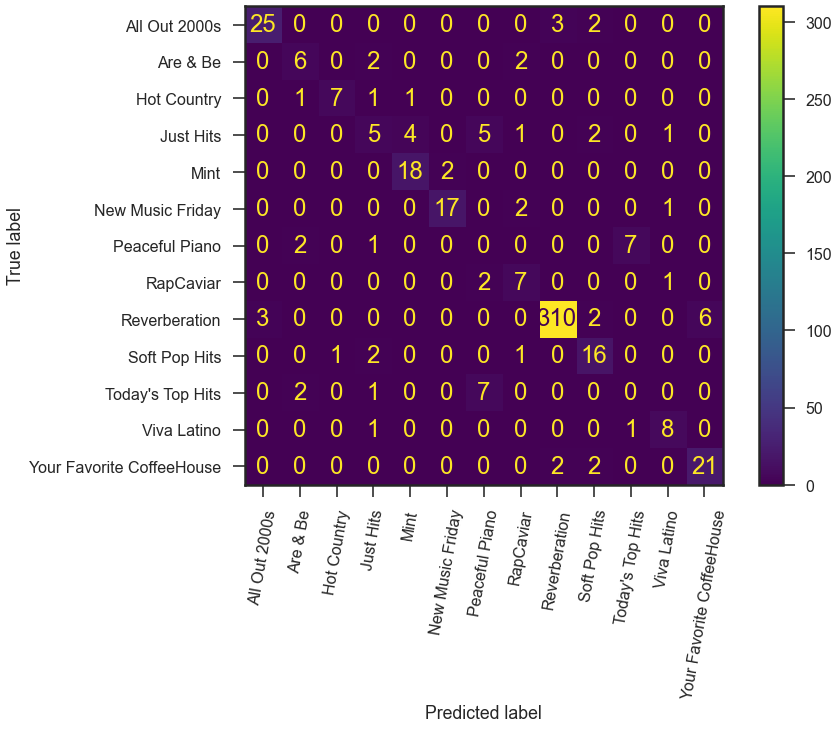

In [61]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb.classes_)
disp.plot()
plt.xticks(rotation=80)
plt.show()

In [62]:
print(f'Accuracy for train data:   {accuracy_score(y_train, y_train_pred):.3f}\n')
print(f'Accuracy for test data:    {accuracy_score(y_test, y_test_pred):.3f}\n')
print(f"Matthew's correlation coefficient for test data:    {matthews_corrcoef(y_test, y_test_pred):.3f}\n")
print('--------------------\n')
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(f'Classification report for test data:\n\n{classification_report(y_test, y_test_pred,zero_division=0)}')
#https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

Accuracy for train data:   0.945

Accuracy for test data:    0.856

Matthew's correlation coefficient for test data:    0.762

--------------------

Classification report for test data:

                           precision    recall  f1-score   support

            All Out 2000s       0.89      0.83      0.86        30
                 Are & Be       0.55      0.60      0.57        10
              Hot Country       0.88      0.70      0.78        10
                Just Hits       0.38      0.28      0.32        18
                     Mint       0.78      0.90      0.84        20
         New Music Friday       0.89      0.85      0.87        20
           Peaceful Piano       0.00      0.00      0.00        10
                RapCaviar       0.54      0.70      0.61        10
            Reverberation       0.98      0.97      0.97       321
            Soft Pop Hits       0.67      0.80      0.73        20
         Today's Top Hits       0.00      0.00      0.00        10
        

In [105]:
# %%time
best_params_={'over_sampler__k_neighbors': 3, 'classifier__subsample': 0.8999999999999999, 'classifier__n_estimators': 1000, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 0.8999999999999999, 'classifier__colsample_bylevel': 0.7}

param_grid= {key:[value] for (key,value) in best_params_.items()}

# Pipeline settings
xgb = Pipeline_imb(steps=[('preprocessor', preprocessor)
                          ,('over_sampler', SMOTE(sampling_strategy='not majority'
                                                     ,random_state=72
                                                     #,smote=SMOTE(k_neighbors=3)
                                                     #,enn=EditedNearestNeighbours(n_neighbors=3)
                                                    ))
                          #,('label_encoder', LabelEncoder())
                          ,('classifier', XGBClassifier(eval_metric='mlogloss'))])

CV = GridSearchCV(xgb, param_grid, scoring='f1_weighted', verbose=1) 

CV.fit(X_train, y_train)
print(CV.best_params_)    
print(CV.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

{'classifier__colsample_bylevel': 0.7, 'classifier__colsample_bytree': 0.8999999999999999, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 6, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.8999999999999999, 'over_sampler__k_neighbors': 3}
0.8597786551284617


In [106]:
y_test_pred = CV.predict(X_test)

In [45]:
cm = confusion_matrix(y_test,y_test_pred)

In [46]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=CV.classes_)
disp.plot()
plt.xticks(rotation=80)
plt.show()

NameError: name 'CV' is not defined

In [47]:
print(f'Accuracy for train data:   {accuracy_score(y_train, y_train_pred):.3f}\n')
print(f'Accuracy for test data:    {accuracy_score(y_test, y_test_pred):.3f}\n')
print(f"Matthew's correlation coefficient for test data:    {matthews_corrcoef(y_test, y_test_pred):.3f}\n")
print('--------------------\n')
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(f'Classification report for test data:\n\n{classification_report(y_test, y_test_pred,zero_division=0)}')
#https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

Accuracy for train data:   0.961

Accuracy for test data:    0.870

Matthew's correlation coefficient for test data:    0.781

--------------------

Classification report for test data:

                           precision    recall  f1-score   support

            All Out 2000s       0.96      0.83      0.89        30
                 Are & Be       0.60      0.60      0.60        10
              Hot Country       0.80      0.80      0.80        10
                Just Hits       0.35      0.39      0.37        18
                     Mint       0.89      0.80      0.84        20
         New Music Friday       0.90      0.90      0.90        20
           Peaceful Piano       0.00      0.00      0.00        10
                RapCaviar       0.60      0.60      0.60        10
            Reverberation       0.98      0.99      0.98       321
            Soft Pop Hits       0.68      0.65      0.67        20
         Today's Top Hits       0.00      0.00      0.00        10
        

---
## 6. Conclusion <a name='6'></a> 
<a href='#00'>(Go to Table of Content)</a>

---
# <a><center> The End </center></a>
<center><b>Author: Ulysse Zampogna</b></center>